# Running Machine Learning tasks with DAT (Deployable Analysis environmenT) 

Problem at hand:
Train a Machine Learning model on sparse data. Use the model to predict the target variables as map in space and time. 

![data](./figs/big.jpg)

This notebook shows a simple workflow to:

- train a RandomForest model 
- Preprocess data
- Run the model 

This notebook and data are based on the research carried by Qianqian Han https://doi.org/10.5194/egusphere-egu24-5488.

This notebook is available at https://github.com/RS-DAT/JupyterDask-Examples


## Model training 

### Introducing `dask`, `dask-ml`, `MultiOutputRegressor`

In [1]:
import os 
import dcachefs

import numpy as np
import pandas as pd

import dask
import dask.dataframe as dd

from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor

from dask_ml.model_selection import train_test_split
from dask_ml.preprocessing import OneHotEncoder

import joblib

In [2]:
import sys
sys.path.append('.')
from utils import training_testing_preprocess, igbp_to_landcover

In [3]:
parent_in_path = "/scratch/EcoExtreML"
parent_out_path = "/scratch/outputs/model"
os.makedirs(parent_out_path, exist_ok=True)
              
input_vars = ['Rin', 'Rli', 'p', 'Ta', 'ea', 'u', 'CO2', 'LAI','Vcmo', 'hc', 'Precip_msr','SSM', 'IGBP_veg_long', 
              'Rntot', 'LEtot', 'Htot','Gtot', 'Actot', 'SIF685', 'SIF740']

In [4]:
# read data
input_data = f"dcache://pnfs/grid.sara.nl/data/remotesensing/disk/EcoExtreML/model/training_testing_2014.csv"
input_df = dd.read_csv(input_data, storage_options={"block_size": 5*2**20}, usecols=input_vars)

# define one hot encoding for IGBP using dask-ml functions
encoder = OneHotEncoder(sparse_output=False)

# preprocess data
input_df = training_testing_preprocess(input_df)
igbp_class = pd.read_csv(f"{parent_in_path}/auxiliary/IGBP11unique.csv")['0'].unique()
input_df = igbp_to_landcover(input_df, encoder, igbp_class)

In [5]:
# training multiple outputs
x_vars = ['Rin', 'Rli', 'p', 'Ta', 'ea', 'u', 'CO2', 'LAI','Vcmo', 'hc', 'Precip_msr','SSM', *[f'IGBP_veg_long{i}' for i in range(1, 12)]]
x = input_df[x_vars]

y_vars = ['LEtot','Htot','Rntot','Gtot', 'Actot','SIF685', 'SIF740']
y = input_df[y_vars]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=0, shuffle=True)

regressor = MultiOutputRegressor(
    RandomForestRegressor(n_estimators=10,
                          max_depth=20,
                          random_state=0,
                          n_jobs=1,
                          min_samples_split=10,
                          min_samples_leaf=4),
    n_jobs=7,
)

regressor

MultiOutputRegressor(estimator=RandomForestRegressor(max_depth=20,
                                                     min_samples_leaf=4,
                                                     min_samples_split=10,
                                                     n_estimators=10, n_jobs=1,
                                                     random_state=0),
                     n_jobs=7)

In [6]:
# connect to the running Dask cluster
from dask.distributed import Client
client = Client("localhost:8786")
client.upload_file("utils.py")  # upload utility module to workers
client

<Client: 'tcp://10.10.1.237:8786' processes=5 threads=20, memory=78.11 GiB>

In [8]:
# set joblib to use dask
with joblib.parallel_backend('dask'):
    regressor.fit(x_train, y_train)

In [9]:
joblib.dump(regressor, f"{parent_out_path}/model_multi.joblib")
print("model is saved")

model is saved


## Preparing data

### Introducing `xr.open_mfdataset` and `xr.Dataset.to_zarr`

#### skip running during the presentation

This cell needs modifications with regards to I/O paths depending on the infra.

In [ ]:
import os
import dcachefs

import fsspec
import xarray as xr
import rioxarray
from functools import partial

In [ ]:
import sys
sys.path.append('.')
from utils import era5_preprocess, co2_preprocess, fix_coords, fix_time, remove_encoding

In [ ]:
parent_in_path = f"./data/global"
data_paths = {"era5land": f"{parent_in_path}/era5land/*.nc",
            "lai": f"{parent_in_path}/lai_v2/*.nc",
            "ssm": f"{parent_in_path}/ssm/GlobalGSSM11km2014_20240214.tif",
            "co2": f"{parent_in_path}/co2/CAMS_CO2_2003-2020.nc",
            "landcover": f"{parent_in_path}/igbp/landcover10km_global.nc",
            "vcmax": f"{parent_in_path}/vcmax/TROPOMI_Vmax_Tg_mean10km_global.nc",
            "canopyheight": f"{parent_in_path}/canopy_height/canopy_height_11kmEurope20230921_10km.nc",
            }

parent_out_path = "somewhere/on/dcache"

# region of interest here EU
bbox = [-31.28903052,  34.93055094,  68.93136141,  81.85192337]

# time series
start_time = "2014-1-31"
end_time = "2014-02-10"

In [ ]:
def open_files(paths):
    ofs = fsspec.open_files(paths, block_size=5*2**20)
    return [of.open() for of in ofs]

In [ ]:
chunks = 500

co2_partial_func = partial(co2_preprocess, start_time=start_time, end_time=end_time)

for data_path in data_paths:
    ofs = open_files(data_paths[data_path])
    # read data    
    if data_path == "era5land":
        ds = xr.open_mfdataset(ofs, engine="h5netcdf", preprocess=era5_preprocess)
    
    elif data_path == "co2":
        ds = xr.open_mfdataset(ofs, engine="h5netcdf", preprocess=co2_partial_func)
        ds = ds.assign_coords(longitude=(((ds.longitude + 180) % 360) - 180))
        
    elif data_path == "ssm":  # this is a tif data
        ds = rioxarray.open_rasterio(ofs[0])
        ds = fix_coords(ds.to_dataset(name="ssm"))       

    else:
        ds = xr.open_mfdataset(data_paths[data_path], preprocess=fix_coords)
        
    # convert day of year
    ds = fix_time(ds, start_time)
    
    # select data subset
    ds_sorted = ds.sortby(['longitude', 'latitude'])
    masked_ds = ds_sorted.sel(longitude=slice(bbox[0], bbox[2]), latitude=slice(bbox[1], bbox[3]), time=slice(start_time, end_time))
    
    # remove global encoding
    masked_ds = remove_encoding(masked_ds)
    
    masked_ds = masked_ds.chunk(chunks=chunks)
    
    # save data to zarr
    out_path = f"{parent_out_path}/{data_path}_{start_time}_{end_time}_EU.zarr"
    fs_map = fsspec.get_mapper(out_path)
    masked_ds.to_zarr(fs_map, mode='w')
    print(f"{out_path} is saved")
    print("=======================================")

## Data processing: 
- Interpolations in space and time
- Variable derivation
- Unit conversion

Skip running during the presentation, these tasks are implemented in the notebook [DataProcessing_BigData.ipynb](./extra/DataProcessing_BigData.ipynb).

## Model prediction

### Introducing `xr.map_blocks`

In [10]:
import os
import fsspec

import xarray as xr
import numpy as np
import dask.array as da

from joblib import load

In [11]:
import sys
sys.path.append('.')
from utils import arr_to_ds

In [12]:
start_time = "2014-1-31"
end_time = "2014-02-10"

parent_in_path = "/scratch/EcoExtreML"
parent_out_path = "dcache://pnfs/grid.sara.nl/data/remotesensing/disk/EcoExtreML/out"
os.makedirs(parent_out_path, exist_ok=True)

chunks = {"time": 100, "longitude": 200, "latitude": 200}

model_input_file = f"dcache://pnfs/grid.sara.nl/data/remotesensing/disk/EcoExtreML/EU/model_input_{start_time}_{end_time}_EU.zarr"
fs_map = fsspec.get_mapper(model_input_file, block_size=10*2**20)
model_input = xr.open_zarr(fs_map)
model_input = model_input.chunk(chunks)

In [13]:
# load model
path_model = f"{parent_in_path}/model/model_multi.joblib"
with open(path_model, 'rb') as f:
    model = load(f)
model

MultiOutputRegressor(estimator=RandomForestRegressor(max_depth=20,
                                                     min_samples_leaf=4,
                                                     min_samples_split=10,
                                                     n_estimators=10, n_jobs=1,
                                                     random_state=0),
                     n_jobs=7)

In [14]:
input_vars = [
    'Rin', 'Rli', 'p', 'Ta', 'ea', 'u', 'CO2', 'LAI', 'Vcmo','hc', 'Precip_msr',  
    'SSM',  *[f'IGBP_veg_long{i}' for i in range(1, 12)]
]

# select input/output data 
input_ds = model_input[input_vars]
output_vars = ['LEtot','Htot','Rntot','Gtot', 'Actot','SIF685', 'SIF740']

In [15]:
def predictFlux(input_ds, model, output_vars):

    df_features = input_ds.to_dataframe().reset_index().drop(columns=["time", "longitude", "latitude"])
    
    # Convert the nan value as 0 for the calculation
    df_features = df_features.fillna(0)
    
    LEH = model.predict(df_features)
    
    output_ds = arr_to_ds(LEH, input_ds, output_vars)
    return output_ds

In [16]:
# define output template
output_temp = xr.Dataset()
ds_shape = (input_ds.sizes['time'], input_ds.sizes['latitude'], input_ds.sizes['longitude'])

for var in output_vars:
    output_temp[var] = xr.DataArray(
        name = var,
        data=da.zeros(ds_shape),
        dims=input_ds.dims,
        coords=input_ds.coords,
    )
output_temp = output_temp.chunk(chunks) # the same chunk as input

In [17]:
# result
output_ds = xr.map_blocks(
    predictFlux,
    input_ds,
    kwargs={
        "model": model, 
        "output_vars": output_vars, 
    },
    template=output_temp,
)

# save data
out_path = f"{parent_out_path}/predicted_{start_time}_{end_time}_EU.zarr"
fs_map = fsspec.get_mapper(out_path)
output_ds.to_zarr(fs_map, mode='w')
print(f"{out_path} is saved")

/opt/conda/envs/jupyterdask/lib/python3.9/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 71.62 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


dcache://pnfs/grid.sara.nl/data/remotesensing/disk/EcoExtreML/out/predicted_2014-1-31_2014-02-10_EU.zarr is saved


In [18]:
output_ds = xr.open_zarr(fs_map)

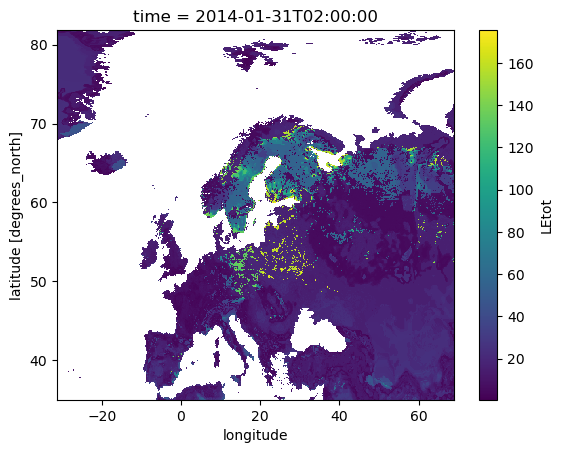

In [19]:
output_ds.LEtot.isel(time=2).plot()

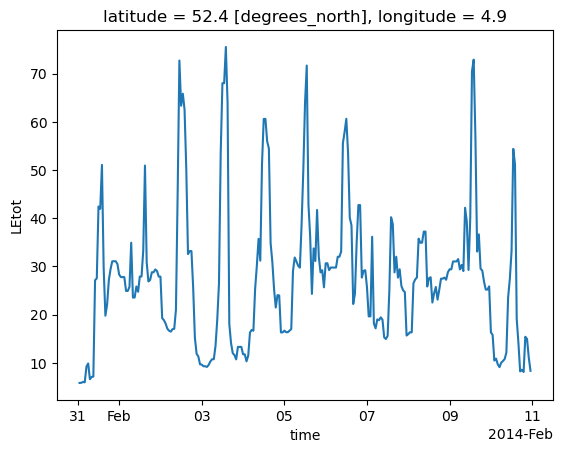

In [20]:
output_ds.LEtot.sel(latitude=(52.36),longitude=(4.90), method='nearest').plot()

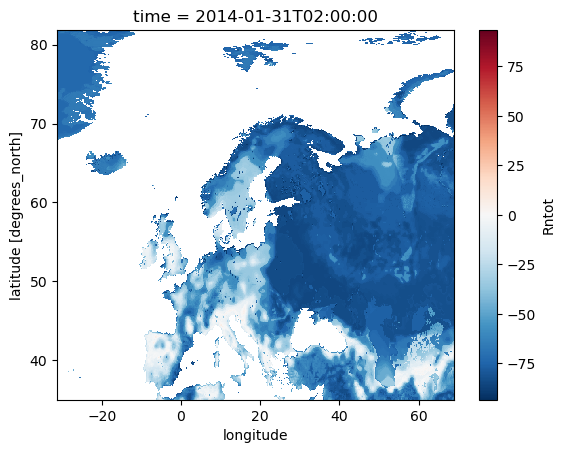

In [21]:
output_ds.Rntot.isel(time=2).plot()

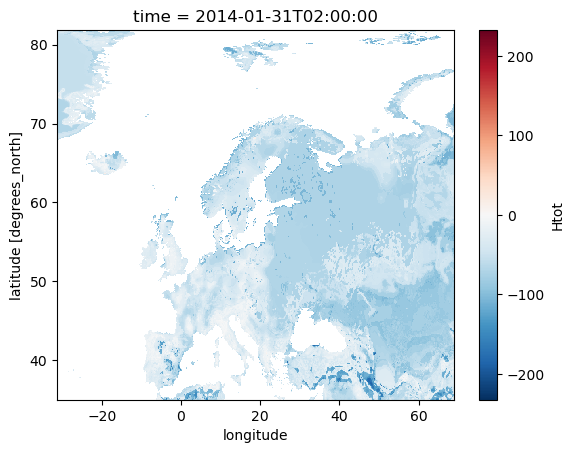

In [23]:
output_ds.Htot.isel(time=2).plot()